# CONV NETS Testing

In [14]:
import numpy as np
import tensorflow as tf
import h5py
from utils import load_dataset
from utils import convert_to_one_hot
from utils import random_mini_batches
from layers.convolutional_layer import Conv
from layers.fullyconnected import FullyConnected
from layers.flatten import Flatten
from activations import relu, lkrelu, linear, sigmoid, cross_entropy
from neural_network import Network
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

In [15]:
(X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes) = load_dataset()

In [16]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1080
number of test examples = 120


## Example of a Picture

y = 4


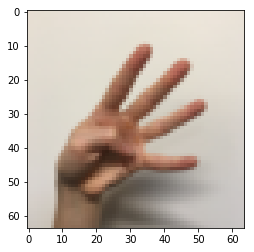

In [17]:
# Example of a picture
index = 17
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
plt.show()

In [18]:
layers = [
        Conv((5, 5, 3, 8), strides=1, activation=relu, filter_init=lambda shp: np.random.normal(size=shp) * np.sqrt(1.0 / (28*28 + 13*13*20)) ),
        Conv((3, 3, 8, 16), strides=1, activation=relu, filter_init=lambda shp:  np.random.normal(size=shp) *  np.sqrt(1.0 / (13*13*20 + 5*5*40)) ),
        Flatten((3, 3, 16)),
        FullyConnected((3*3*16, 20), activation=sigmoid, weight_init=lambda shp: np.random.normal(size=shp) * np.sqrt(1.0 / (5*5*40 + 100.))),
        FullyConnected((20, 6), activation=linear, weight_init=lambda shp: np.random.normal(size=shp) * np.sqrt(1.0 / (110.)))
    ]

In [19]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    return X, Y

In [20]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [4,4,3,8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    parameters = {"W1": W1,
                  "W2": W2}
    return parameters

In [21]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=6, activation_fn=None)

    return Z3

In [22]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

In [23]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y) # Create Placeholders of the correct shape
    parameters = initialize_parameters()              # Initialize parameters
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            epoch_cost = 0
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})                
                epoch_cost += minibatch_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.917929
Cost after epoch 5: 1.506757
Cost after epoch 10: 0.955359
Cost after epoch 15: 0.845802
Cost after epoch 20: 0.701174
Cost after epoch 25: 0.571977
Cost after epoch 30: 0.518435
Cost after epoch 35: 0.495806
Cost after epoch 40: 0.429827
Cost after epoch 45: 0.407291
Cost after epoch 50: 0.366394
Cost after epoch 55: 0.376922
Cost after epoch 60: 0.299491
Cost after epoch 65: 0.338870
Cost after epoch 70: 0.316400
Cost after epoch 75: 0.310413
Cost after epoch 80: 0.249549
Cost after epoch 85: 0.243457
Cost after epoch 90: 0.200031
Cost after epoch 95: 0.175452


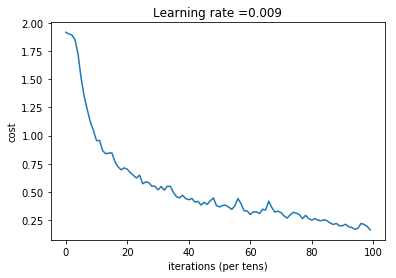

Tensor("Mean_1:0", shape=(), dtype=float32)
('Train Accuracy:', 0.94074076)
('Test Accuracy:', 0.78333336)


In [24]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

Cost after epoch 0: 1.797793
Cost after epoch 5: 1.062814
Cost after epoch 10: 0.733787
Cost after epoch 15: 0.669581
Cost after epoch 20: 0.555776
Cost after epoch 25: 0.457239
Cost after epoch 30: 0.404166
Cost after epoch 35: 0.340715
Cost after epoch 40: 0.331293
Cost after epoch 45: 0.288620
Cost after epoch 50: 0.291059
Cost after epoch 55: 0.217866
Cost after epoch 60: 0.225433
Cost after epoch 65: 0.182873
Cost after epoch 70: 0.215192
Cost after epoch 75: 0.137958
Cost after epoch 80: 0.129231
Cost after epoch 85: 0.197948
Cost after epoch 90: 0.106846
Cost after epoch 95: 0.075783
Cost after epoch 100: 0.151517
Cost after epoch 105: 0.080641
Cost after epoch 110: 0.078682
Cost after epoch 115: 0.068968
Cost after epoch 120: 0.098942
Cost after epoch 125: 0.075876
Cost after epoch 130: 0.173409
Cost after epoch 135: 0.036180
Cost after epoch 140: 0.028859
Cost after epoch 145: 0.023208
Cost after epoch 150: 0.015024
Cost after epoch 155: 0.014136
Cost after epoch 160: 0.012874

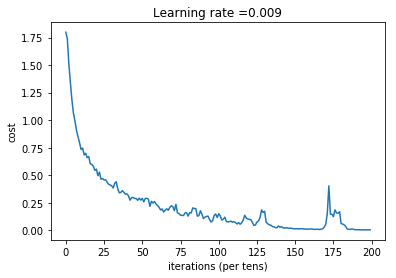

Tensor("Mean_1:0", shape=(), dtype=float32)
('Train Accuracy:', 1.0)
('Test Accuracy:', 0.85833335)


In [27]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, 
                         num_epochs = 200, minibatch_size = 40)